## Convirtiendo un pdf en markdown

If you want begin with a more simple example [pdf2images.ipynb]("./pdf2images.ipynb")

## pdf to markdowns

* Define your Documents and Transformers

In [1]:
# Install pdf2image for this example
# !pip install pdf2image

In [3]:
from document_transformer import Document, DocumentTransformer
from typing import List
from pathlib import Path
import pdf2image

class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class MarkdownDocument(Document):
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

class PDF2Images(DocumentTransformer):
    input: PDFDocument = None
    output: List[ImageDocument] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        return [
            ImageDocument(
                metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                data=image,
            )
            for i, image in enumerate(images)
        ]

* Define the `Image2Markdown` transformer, which takes an `ImageDocument` and transforms it into a `MarkdownDocument`.
* To keep things simple, we'll define an OCR method with dummy data. However, it's important that you implement your own OCR logic here.

In [4]:
class Image2Markdown(DocumentTransformer):
    input: ImageDocument = None
    output: MarkdownDocument = None

    def ocr(self):
        """ocr, puede ser una función externa"""
        return f"OCR {self.input.metadata['page']}"

    def transformer(self):
        ocr_text = self.ocr()
        return MarkdownDocument(
            metadata={'image_path': self.input.path, 'page': self.input.metadata['page']},
            data=ocr_text
        )

run it!

In [5]:
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

for image in images:
    image.save(path=f'images/pag_{image.metadata["page"]}.jpg')
    markdown = Image2Markdown(input=image).run()
    markdown.save(path=f'images/pag_{image.metadata["page"]}.md')
    print(markdown)

id='841c3afb-e2e1-4e83-b62c-3676a714365a' path='images/pag_1.md' data='OCR 1' metadata={'image_path': 'images/pag_1.jpg', 'page': 1} parents={'371e7643-6068-4051-b216-8f5c4d58f893'} childrens=set()
id='f6d58803-04de-41ba-a02b-dd1cedc1d7ea' path='images/pag_2.md' data='OCR 2' metadata={'image_path': 'images/pag_2.jpg', 'page': 2} parents={'e49b9084-8642-49ff-9442-2261713b6a8c'} childrens=set()
id='162021ac-f170-4eee-9867-ce2f8f2870dd' path='images/pag_3.md' data='OCR 3' metadata={'image_path': 'images/pag_3.jpg', 'page': 3} parents={'0bab29a7-807f-4468-9018-29f532f4c078'} childrens=set()


Now the diversion! Use your document transformer

In [6]:
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

for image in images:
    image.save(path=f'images/pag_{image.metadata["page"]}.jpg')
    print(f"Imagen: {image.id}")
    print(f"Parents: {image.parents}")
    print(f"Metadata: {image.metadata}")

Imagen: ada9b8af-b710-42ad-b359-aae7e18e9de5
Parents: {'1d2de597-fe25-4342-8aac-630a23c588a1'}
Metadata: {'pdf_path': 'document.pdf', 'page': 1, 'size': (1700, 2200)}
Imagen: 39342d23-fb80-423b-9bff-acaa65259ff2
Parents: {'1d2de597-fe25-4342-8aac-630a23c588a1'}
Metadata: {'pdf_path': 'document.pdf', 'page': 2, 'size': (1700, 2200)}
Imagen: fd69fe00-eb55-4620-9e25-c68d91a26a60
Parents: {'1d2de597-fe25-4342-8aac-630a23c588a1'}
Metadata: {'pdf_path': 'document.pdf', 'page': 3, 'size': (1700, 2200)}


* If you prefier, you can define a `Pipeline`.
* In a list insert each transformer  and plot it!

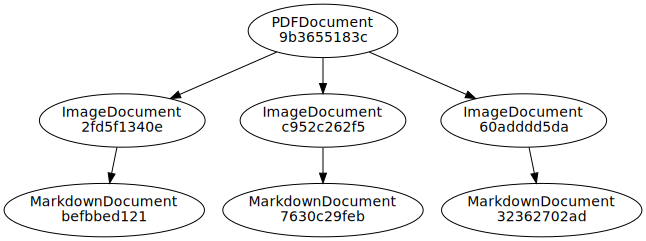

In [7]:
from document_transformer import Pipeline
from document_transformer.utils import plot_graph

pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[PDF2Images(), Image2Markdown()])
markdowns = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

All is ok?
Save only markdowns!

In [8]:
for markdown in markdowns:
    markdown.save(path=f'images/pag_{markdown.metadata["page"]}.md')

But if you prefer, you can instruct from Pipeline directly!

In [9]:
pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[
    PDF2Images(),
    Image2Markdown(to='images/pag_{metadata[page]}.md')
])

pipeline.run(input=pdf_doc)

[MarkdownDocument(id='89e770b1-f2a1-4f0b-8c9c-2b84f172a27c', path='images/pag_1.md', data='OCR 1', metadata={'image_path': None, 'page': 1}, parents={'5b4f6a03-6a88-446c-8a0c-72590ce6c963'}, childrens=set()),
 MarkdownDocument(id='b7584177-842d-4988-a9ca-764ea8f9dec8', path='images/pag_2.md', data='OCR 2', metadata={'image_path': None, 'page': 2}, parents={'8b151c46-4501-46c8-8ce5-9147c3b4ced6'}, childrens=set()),
 MarkdownDocument(id='eda63fe8-4fec-45e7-9b2d-ad8359261e1d', path='images/pag_3.md', data='OCR 3', metadata={'image_path': None, 'page': 3}, parents={'4d1f232d-e737-4b6e-9a78-898a73df6812'}, childrens=set())]

## Combine markdowns

Now, we are going to merge the markdowns. For that we need to increase the skills of `MarkdownDocument`. Let me define the `appender` method.

In [10]:
class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self


That is all, now we can to append each markdown document to another

In [11]:
# create images
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

# Initialize the markdown document
markdown_doc = MarkdownDocument()
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdown_doc.append(markdown)

markdown_doc.save(path="document.md")

MarkdownDocument(id='bd016f9f-9423-4bea-b2cd-452f48ff7e12', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'b4232146-8306-476f-b091-4e42bb07179f', '766f95a7-b3a9-4439-b1e6-2df07a92ad53', 'b7767ed3-dfc5-42b4-98cb-7b16e946857f'}, childrens=set())

The library supports initializing an empty list and combining markdown documents at the end


In [12]:

pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

# initialize an empty list of markdowns
markdowns = []
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdowns.append(markdown)

# Combine them into a single markdown document and save it
markdown_doc = MarkdownDocument().extend(markdowns)
markdown_doc.save(path="document.md")

MarkdownDocument(id='82f9db83-b6b8-4c27-b4a5-3a4cd13048c2', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'eaf83e45-b025-4625-8d92-b5030fb06030', 'ecf0ac69-963a-4c91-9165-96e6aadcf70d', 'c9b7082a-08e6-4d3e-a44a-c7f25fd54956'}, childrens=set())

Alternatively, you can always create a `DocumentTransformer` class to handle this task


In [13]:
class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)

pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

markdowns = []
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdowns.append(markdown)

markdown_doc = CombineMarkdowns(input=markdowns).run()
markdown_doc.save(path="document.md")

MarkdownDocument(id='6ef0a3a9-17d0-4739-bfce-c14064f38ee7', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'56cfb795-8f7e-489e-81ce-319e5d42a93e', '0dc61975-6236-467e-a578-cf9b0598728c', 'c496eca0-50b7-4c1d-89e9-144ee50818eb'}, childrens=set())

Which brings a reward! Now you can extend your Pipeline

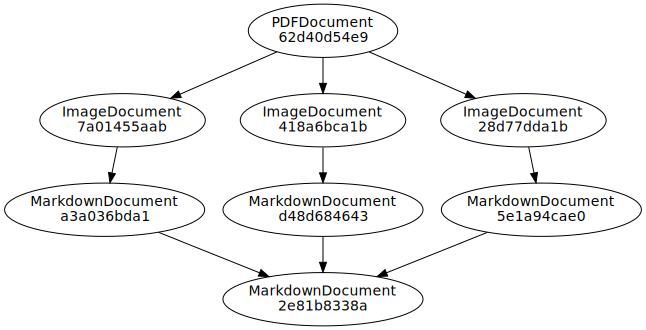

In [14]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Images(), Image2Markdown(), CombineMarkdowns()
])

# Run and visualize it!
pdf_doc = PDFDocument(path="document.pdf")
markdown_doc = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

In [15]:
pipeline.get_traces()

[{'id': '9bd8d13b-66ef-4ed9-88c0-0b62d40d54e9',
  'path': 'document.pdf',
  'type': 'PDFDocument',
  'childrens': ['103f92cf-ec99-42ae-b925-347a01455aab',
   '37274468-50ca-4628-9a4c-cd418a6bca1b',
   'fe48ba49-fad4-4461-a36a-0728d77dda1b'],
  'parents': []},
 {'id': '103f92cf-ec99-42ae-b925-347a01455aab',
  'path': None,
  'type': 'ImageDocument',
  'childrens': ['af047b95-cb44-4d98-9cff-21a3a036bda1'],
  'parents': ['9bd8d13b-66ef-4ed9-88c0-0b62d40d54e9']},
 {'id': 'fe48ba49-fad4-4461-a36a-0728d77dda1b',
  'path': None,
  'type': 'ImageDocument',
  'childrens': ['beb44ad0-a03d-44d1-988b-d95e1a94cae0'],
  'parents': ['9bd8d13b-66ef-4ed9-88c0-0b62d40d54e9']},
 {'id': '37274468-50ca-4628-9a4c-cd418a6bca1b',
  'path': None,
  'type': 'ImageDocument',
  'childrens': ['173e9959-96ce-43f6-8e99-fad48d684643'],
  'parents': ['9bd8d13b-66ef-4ed9-88c0-0b62d40d54e9']},
 {'id': 'af047b95-cb44-4d98-9cff-21a3a036bda1',
  'path': None,
  'type': 'MarkdownDocument',
  'childrens': ['f9e9d843-7c83-48e

Remember, if you need to save each part, you can specify it in the Pipeline


In [16]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Images(to='images/pag_{metadata[page]}.jpg'),
    Image2Markdown(to='images/pag_{metadata[page]}.md'),
    CombineMarkdowns(to='document.md')
])

# Run it!
pdf_doc = PDFDocument(path="document.pdf")
pipeline.run(input=pdf_doc)

MarkdownDocument(id='8064184f-8dea-46ec-a122-eceb67247954', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'f07ef07b-c0a8-4bc4-9c50-7580e4af4458', '1b635c87-66ac-4394-bc46-6a987377b2b6', 'd90ea034-b2ef-4c19-bdb9-6e364621913c'}, childrens=set())

## All togheter!

Next all definitions and final Pipeline. Insert more than one input document if you need it!

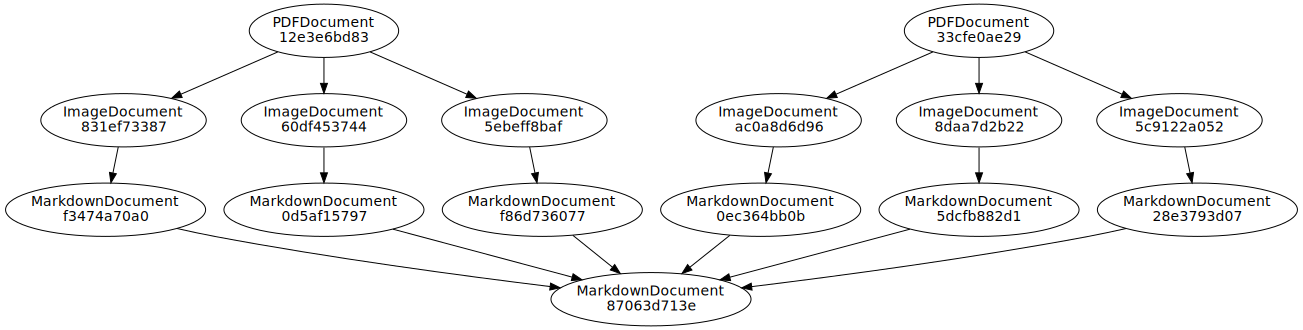

In [17]:
from document_transformer import Document, DocumentTransformer
from document_transformer.utils import plot_graph
from typing import List
from pathlib import Path
import pdf2image

######################################################
# Documents
######################################################
class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self

######################################################
# Transfomers
######################################################
class PDF2Images(DocumentTransformer):
    input: PDFDocument = None
    output: List[ImageDocument] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        return [
            ImageDocument(
                metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                data=image,
            )
            for i, image in enumerate(images)
        ]

class Image2Markdown(DocumentTransformer):
    input: ImageDocument = None
    output: MarkdownDocument = None

    def ocr(self):
        """ocr, puede ser una función externa"""
        return f"OCR {self.input.metadata['page']}"

    def transformer(self):
        ocr_text = self.ocr()
        return MarkdownDocument(
            metadata={'image_path': self.input.path, 'page': self.input.metadata['page']},
            data=ocr_text
        )

class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)
    

######################################################
# Pipeline
######################################################
pipeline = Pipeline(transformers=[
    PDF2Images(to='images/pag_{metadata[page]}.jpg'),
    Image2Markdown(to='images/pag_{metadata[page]}.md'),
    CombineMarkdowns(to='document.md')
])

# Run it!
pdf_doc1 = PDFDocument(path="document.pdf")
pdf_doc2 = PDFDocument(path="document.pdf")

markdown_doc = pipeline.run(input=[pdf_doc1, pdf_doc2])
plot_graph(pipeline.get_traces())

## Conclusions

As you can see, `document-transformer` is your friend when it comes to organizing your transformer pipeline. Simply define your components, and `document-transformer` will handle the rest, ensuring traceability and organization. Reuse your work in any project!